In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Предварительно зададим функции для вычисления матричной нормы, числа обусловленности и алгоритм Гаусса

In [172]:
def gaussForwardSweep(AMatrix, inplace=False):
    """ Forward sweep для Гаусса """
    A = AMatrix if inplace else AMatrix.copy()
    
    m = A.shape[0] # Number of equations
    factorListSteps = []
    
    def getFactor(step, num): return (A[num][step]/A[step][step])
    
    def applyFactor(step, row, factorList):
        factor = getFactor(step, row)
        factorList.append(factor)
        A[row] = A[row] - factor * A[step]
    
    # For every step...
    for step in range(0, m-1):
        # Save here all the factors in this step:
        factorListTmp = []
        # Do the elimination thingy:
        for row in range(step+1, m):
            applyFactor(step, row, factorListTmp)
        # Then save all the factors in the step 
        # to the array of arrays:
        factorListSteps.append(factorListTmp)
    
    return (A, np.array([np.array(factorList) 
                         for factorList in factorListSteps]))

In [288]:
def applyFactors2b(bList, factorListBySteps, inplace=False):
    """ Функция, вычисляющая вектор b', соответствующий применению 
    к вектору b последовательности преобразований матрицы A при forward pass.
    
    factorListBySteps -- np.array(np.array([...]), np.array([...]), ...)
    """
    b = bList if inplace else bList.copy()
    #print(factorListBySteps)
    m = b.shape[0]
    for step in range(0, m-1):
        #print('step:', step, "b:", b)
        #print(factorListBySteps[step])
        b[step+1:] = b[step+1:] - factorListBySteps[step] * b[step]
    return b

In [268]:
def gaussBackwardSubstitution(A_fs, b_applied):
    """ Gauss Backward Substitution
    Arguments:
    A_fs -- Matrix of system after Forward Pass (upper triangle)
    b_applied -- vector b after forward pass
    """
    m = A_fs.shape[0]
    
    x = np.empty(m)
    m -= 1 # Because we are indexing from 0
    x[m] = b_applied[m]/A_fs[m][m]
    for i in range(m-1, -1, -1):
        #print('>',i)
        #print(np.sum(A[i][i+1:] * x[i + 1:]))
        x[i] = (b_applied[i] - np.sum(A_fs[i][i+1:] * x[i+1:]))/A_fs[i][i]
    return x

In [269]:
def gaussNaive(A, b):
    """ Наивный алгоритм Гаусса без пивотинга """
    m = A.shape[0]
    # >>> Forward sweep <<<
    if A[0][0] == 0:
        print("a_00 = 0. Use pivoting, sucker!")
        return
    
    # Do a forward sweep and get an array of all the factors:
    A, factors = gaussForwardSweep(A)
    # Apply factors from the array of factors to vector b:
    b = applyFactors2b(b, factors)
    
    # >>> Back substitution <<<
    x = gaussBackwardSubstitution(A, b)
    return x

In [229]:
def gaussCheck(A, solution):
    """ Функция проверки работы алгоритма Гаусса.
    На входе -- матрица системы и вектор решений
    """
    results = []
    for i in range(A.shape[0]):
        q = 0
        for j in range(A.shape[1]):
            q += A[i][j] * solution[j]
        results.append(q)
    return results

In [240]:
# inf норма матрицы
def mtrInfNorm(M):
    return np.linalg.norm(M, np.inf)

In [242]:
# Число обусловленности для матрицы по inf норме
def condi(M):
    return mtrInfNorm(M) * mtrInfNorm(np.linalg.inv(M))

# Задача 3.1

$$ N = 24; n = 4 $$
$$ b_i = N, \forall i=1..n$$

$$ a_{i, j} = \frac{159}{10 c_{i, j}^3 + c_{i, j}^2 + 25}$$

$$ c_{i, j} = 0.1\cdot N\cdot i\cdot j, \forall i, j = 1..n $$

## пт.1) Зададим матрицу $A$ и вектор $b$. Потом решим полученную систему

In [249]:
def c_ij(i, j, N): 
    return 0.1 * N * i * j

In [250]:
def a_ij(i, j, N, func_c):  
    c = func_c(i, j, N)
    a = 159/(10 * np.power(c, 3) + np.power(c, 2) + 25)
    return a

In [257]:
def genA(N, n, func_a, func_c):
    A = np.empty((n, n))
    for row in range(n):
        a_row = [func_a(row, j, N, func_c) for j in range(n)]
        A[row] = a_row
    return A

### Определим константы (номер варианта, размерность системы)

In [256]:
N = 24
n = 4

### И, наконец, сгенерируем матрицу $A$

In [258]:
A = genA(N, n, a_ij, c_ij)
A

array([[  6.36000000e+00,   6.36000000e+00,   6.36000000e+00,
          6.36000000e+00],
       [  6.36000000e+00,   9.40828402e-01,   1.37786405e-01,
          4.17397331e-02],
       [  6.36000000e+00,   1.37786405e-01,   1.77365882e-02,
          5.28376124e-03],
       [  6.36000000e+00,   4.17397331e-02,   5.28376124e-03,
          1.57008318e-03]])

In [274]:
b = np.full(n, N, dtype=float)
b

array([ 24.,  24.,  24.,  24.])

### Решим полученныю систему

In [270]:
sol = gaussNaive(A, b)
sol

[array([ 1.,  1.,  1.]) array([ 1.14818538,  1.16590888])
 array([ 1.12197958])]
step: 0 b: [24 24 24 24]
[ 1.  1.  1.]
step: 1 b: [24  0  0  0]
[ 1.14818538  1.16590888]
step: 2 b: [24  0  0  0]
[ 1.12197958]


array([ 3.77358491, -0.        ,  0.        , -0.        ])

### Проверим корректность работы алгоритма

In [261]:
gaussCheck(A, sol)

[24.0, 24.0, 24.0, 24.0]

## пт.2) Вычислим число обусловленности матрицы $A$

In [262]:
matrixACondNumber = condi(A)
matrixACondNumber

42886.344666270939

We have a poorly-conditioned system

## пт. 3) Исследование погрешностей

Примем решение sol за точное. Вычислим следующие величины:

$$ d = (d_1, ..., d_n)^T$$

$ d_i = \frac{\Vert x - x^i \Vert _{\infty}}{\Vert x \Vert _\infty}, i = 1..n $, где $ x^i $ -- погрешности решений систем $Ax^i = b^i, i = 1..n$, где $b^i$ вычисляется так:

$$ b^{i}_k = 
   \begin{cases}
        b_k + \varDelta, & k = i \\
        b_k, & k \ne i
    \end{cases}
$$

Где $\varDelta$ -- произвольная погрешность

Значит, нам надо сгенерировать $n$ систем с одинаковыми матрицами $A$, но разными векторами свободных членов, найти их решения и на основе погрешностей этих решений относительно канонического решения составить вектор $d$

In [267]:
DELTA = np.random.rand()
DELTA

0.5432432929685788

### Сгенерируем векторы $b^i$

In [272]:
def genBi(b, n, delta):
    bs = []
    for i in range(n):
        bCur = b.copy()
        bCur[i] = bCur[i] + delta
        bs.append(bCur)
    return np.array(bs)

In [276]:
bVectorsWithDelta = genBi(b, n, DELTA)
bVectorsWithDelta

array([[ 24.54324329,  24.        ,  24.        ,  24.        ],
       [ 24.        ,  24.54324329,  24.        ,  24.        ],
       [ 24.        ,  24.        ,  24.54324329,  24.        ],
       [ 24.        ,  24.        ,  24.        ,  24.54324329]])

### Используя приведенную к верхнетреугольному виду матрицу $A$ решим системы при разных векторах свободных членов

In [278]:
A_forwardSweep, b_factors = gaussForwardSweep(A)
print(A_forwardSweep)

[[  6.36000000e+00   6.36000000e+00   6.36000000e+00   6.36000000e+00]
 [  0.00000000e+00  -5.41917160e+00  -6.22221359e+00  -6.31826027e+00]
 [  0.00000000e+00   0.00000000e+00   8.01991263e-01   8.99817821e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.49141055e-03]]


In [289]:
solutions = []
for b_vector in bVectorsWithDelta:
    bVectorAppliedFactors = applyFactors2b(b_vector, b_factors)
    curSol = gaussBackwardSubstitution(A_forwardSweep, bVectorAppliedFactors)
    solutions.append(curSol)

### Полученные решения систем

In [290]:
solutions

[array([  3.77358491e+00,   6.83346225e-04,  -4.35169902e-02,
          1.28249248e-01]),
 array([  3.77426825,  -4.65823535,  49.21661787, -44.55906587]),
 array([   3.73006792,   49.21661787, -457.85190557,  408.67880469]),
 array([   3.90183415,  -44.55906587,  408.67880469, -364.24798807])]

### Вычислим вектор $b$

In [291]:
b_errors = []
for i in range(n):
    b_error_cur = np.linalg.norm(sol - solutions[i], np.inf)/np.linalg.norm(sol, np.inf)
    b_errors.append(b_error_cur)

In [292]:
b_errors

[0.033986050840938573,
 13.042403735856876,
 121.33075497616122,
 108.29988324271756]

### Построим гистограмму

<Container object of 4 artists>

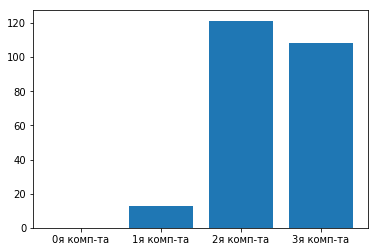

In [307]:
lbl = ["{0}я комп-та".format(i) for i in range(n)]
fig, ax = plt.subplots()
ics = np.arange(4)

ax.set_xticks(ics)
ax.set_xticklabels(lbl)
ax.bar(ics, b_errors)

### Оценим теоретические погрешности $x^m$

In [308]:
theoretical_errors = []
for i in range(n):
    th_error = matrixACondNumber * np.linalg.norm(b - bVectorsWithDelta[i], np.inf)/np.linalg.norm(b, np.inf)
    theoretical_errors.append(th_error)

In [309]:
theoretical_errors

[970.7382958287709, 970.7382958287709, 970.7382958287709, 970.7382958287709]

<Container object of 4 artists>

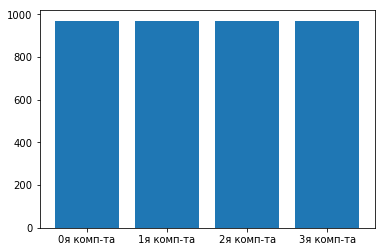

In [310]:
lbl = ["{0}я комп-та".format(i) for i in range(n)]
fig, ax = plt.subplots()
ics = np.arange(4)

ax.set_xticks(ics)
ax.set_xticklabels(lbl)
ax.bar(ics, theoretical_errors)